# Cross-Domain Recommendation System Development
This notebook is an experiment in building a cross-domain recommendation system using the Amazon Reviews dataset. It uses the best model from the single-domain experiments and extends it to handle multiple domains.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from collections import defaultdict

os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
os.environ["HF_DATASETS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"
os.environ["TRANSFORMERS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/models"

# os.environ["HF_HOME"] = "E:/Python Scripts/recsys"
# os.environ['HF_DATASETS_CACHE'] = "E:/Python Scripts/recsys/data"
# os.environ['TRANSFORMERS_CACHE'] = "E:/Python Scripts/recsys/models"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Features, Value
from tqdm import tqdm
from tensorboardX import SummaryWriter

In [2]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Single-domain development on best model (SASRec)

In [3]:
HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"

def load_amazon_reviews(domain, save_dir="data", max_items=None, seed=SEED):
    os.makedirs(save_dir, exist_ok=True)
    filepath = f"{save_dir}/amazon_reviews_{domain}.csv"

    if not os.path.exists(filepath):
        print(f"File {filepath} not found. Downloading dataset for domain '{domain}'...")
        ds = load_dataset(
            "McAuley-Lab/Amazon-Reviews-2023",
            f"raw_review_{domain}",
            split="full",
            trust_remote_code=True,
        )

        # Keep only needed columns
        ds = ds.select_columns(["user_id", "parent_asin", "rating", "timestamp"])
        ds = ds.rename_columns({"user_id": "user", "parent_asin": "item"})
        ds = ds.cast(Features({
            "user": Value("string"),
            "item": Value("string"),
            "rating": Value("float32"),
            "timestamp": Value("int64"),
        }))

        # Convert to pandas (Arrow zero-copy where possible)
        df = ds.to_pandas()
        df.insert(3, "domain", domain)
        df.to_csv(f"{save_dir}/amazon_reviews_{domain}.csv", index=False)
        print(f"Saved amazon_reviews_{domain}.csv to {save_dir}/")

    final_df = pd.read_csv(filepath)
    # Random subset if max_items is set
    if max_items is not None:
        k = min(max_items, len(final_df))
        final_df = final_df.sample(n=k, random_state=seed).reset_index(drop=True)
    print(f"Loaded {filepath} with {len(final_df)} rows.")
    return final_df

def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    # Make it implicit
    df["label"] = 1.0
    user_counts = df.groupby("user").size()
    valid_users = user_counts[user_counts >= min_user_interactions].index
    item_counts = df.groupby("item").size()
    valid_items = item_counts[item_counts >= min_item_interactions].index
    df_filtered = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)]
    print("After interactions filtering:", len(df_filtered), "rows,", df_filtered["user"].nunique(), "users,", df_filtered["item"].nunique(), "items")
    return df_filtered

def label_encoder(df, shift_item_id=False):
    df_encoded = df.copy()
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    domain_enc = LabelEncoder()
    df_encoded["user_id"] = user_enc.fit_transform(df_encoded["user"])
    df_encoded["item_id"] = item_enc.fit_transform(df_encoded["item"])
    if shift_item_id:
        df_encoded["item_id"] = df_encoded["item_id"] + 1  # Shift item IDs by 1 to reserve 0 for padding if needed
    df_encoded["domain_id"] = domain_enc.fit_transform(df_encoded["domain"])
    return df_encoded, user_enc, item_enc, domain_enc

### Dataset preparation

In [4]:
# New input
SOURCE_DOMAIN = "Books"

# Loading data from multiple domains
df = load_amazon_reviews(SOURCE_DOMAIN, max_items=15_000_000, seed=SEED)
print(f"Total rows in {SOURCE_DOMAIN}: {len(df)}")

# Preprocess the dataset
filtered_df = preprocess_dataset(df, min_user_interactions=10, min_item_interactions=10)
df_encoded, user_encoder, item_encoder, domain_encoder = label_encoder(filtered_df, shift_item_id=True)

NUM_USERS = df_encoded["user_id"].max() + 1
NUM_ITEMS = df_encoded["item_id"].max() + 1

Loaded data/amazon_reviews_Books.csv with 15000000 rows.
Total rows in Books: 15000000
After interactions filtering: 2002738 rows, 154220 users, 236541 items


In [5]:
def create_user_sequences(df):
    df_sorted = df.sort_values(["user_id", "timestamp"])
    user_sequences = {}
    for uid, group in df_sorted.groupby("user_id"):
        items = group["item_id"].tolist()
        user_sequences[uid] = items

    print(f"Number of users: {len(user_sequences)}")
    print(f"Max sequence length: {max(len(seq) for seq in user_sequences.values())}")
    print(f"Min sequence length: {min(len(seq) for seq in user_sequences.values())}")

    return user_sequences

# Create sequences
user_sequences = create_user_sequences(df_encoded)
pos_items_by_user = {u: set(seq) for u, seq in user_sequences.items()}

Number of users: 154220
Max sequence length: 1146
Min sequence length: 1


In [6]:
def sequences_loo_split(user_sequences):
    train_seqs = {}
    val_data = {}
    test_data = {}

    for user, seq in user_sequences.items():
        if len(seq) < 3:  # Need at least 3 items for train/val/test
            continue

        train_seqs[user] = seq[:-2]  # All but last two
        val_data[user] = (seq[:-2], seq[-2])  # Train on all but last 2, predict second-to-last
        test_data[user] = (seq[:-1], seq[-1])  # Train on all but last, predict last

    print(f"Training sequences: {len(train_seqs)}")
    print(f"Validation users: {len(val_data)}")
    print(f"Test users: {len(test_data)}")

    return train_seqs, val_data, test_data

train_sequences, val_sequences, test_sequences = sequences_loo_split(user_sequences)
print(f"Sequences - Train: {len(train_sequences)}, Val: {len(val_sequences)}, Test: {len(test_sequences)}")

Training sequences: 145957
Validation users: 145957
Test users: 145957
Sequences - Train: 145957, Val: 145957, Test: 145957


### Dataset and DataLoader

In [7]:
class SASRecDataset(Dataset):
    def __init__(self, data, num_items, max_seq_len=50, pos_items_by_user=None, mode="train", neg_samples=1):
        self.num_items = num_items
        self.max_seq_len = max_seq_len
        self.mode = mode
        self.neg_samples = neg_samples
        self.all_pos = pos_items_by_user

        self.samples = []
        if mode == "train":
            for user, seq in data.items():
                for i in range(1, len(seq)):
                    self.samples.append({
                        "user": user,
                        "input_seq": seq[:i],
                        "target": seq[i],
                        "full_seq": seq # For negative sampling
                    })
        else:
            for user, (seq, target) in data.items():
                self.samples.append({
                    "user": user,
                    "input_seq": seq,
                    "target": target,
                    "full_seq": seq + [target]
                })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        user = sample["user"]
        seq = sample["input_seq"]
        target = sample["target"]

        # Truncate sequence if > max length
        if len(seq) > self.max_seq_len:
            seq = seq[-self.max_seq_len:]

        # Left-pad sequence with zeros
        pad_len = self.max_seq_len - len(seq)
        padded_seq = [0] * pad_len + seq

        # Negative sampling
        forbid = self.all_pos[user] if self.all_pos is not None else set(sample["full_seq"])
        neg_items = set()

        while len(neg_items) < self.neg_samples:
            neg = random.randint(1, self.num_items - 1)
            if neg not in forbid:
                neg_items.add(neg)

        return {
            "user": sample["user"],
            "input_seq": torch.tensor(padded_seq, dtype=torch.long),
            "target": torch.tensor(target, dtype=torch.long),
            "neg_items": torch.tensor(list(neg_items), dtype=torch.long)
        }

# Create datasets
train_dataset = SASRecDataset(train_sequences, NUM_ITEMS, pos_items_by_user=pos_items_by_user, max_seq_len=50, mode="train", neg_samples=4)
val_dataset = SASRecDataset(val_sequences, NUM_ITEMS, pos_items_by_user=pos_items_by_user, max_seq_len=50, mode="val", neg_samples=99)
test_dataset = SASRecDataset(test_sequences, NUM_ITEMS, pos_items_by_user=pos_items_by_user, max_seq_len=50, mode="test", neg_samples=99)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 1551543
Validation samples: 145957
Test samples: 145957


In [8]:
# Create data loaders
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
first = next(iter(train_loader))
print("Sample batch from loader:")
print("Input sequence shape:", first["input_seq"].shape)
print("Target shape:", first["target"].shape)
print("Negative items shape:", first["neg_items"].shape)

batch_size_in_first = first["input_seq"].shape[0]

print("\nSample input sequence:")
random_index = []
for _ in range(5):
    random_index.append(random.randint(0, batch_size_in_first - 1))

for i in random_index:
    print(first["input_seq"][i])

Sample batch from loader:
Input sequence shape: torch.Size([512, 50])
Target shape: torch.Size([512])
Negative items shape: torch.Size([512, 4])

Sample input sequence:
tensor([    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0, 94948, 29184, 29171])
tensor([     0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,  28797, 204941,
        209828, 209614, 141818, 206079, 

### Create SASRec model

In [10]:
# Building SASRec model
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_dim, dropout=0.2):
        super().__init__()
        self.w1 = nn.Linear(hidden_dim, hidden_dim)
        self.w2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(self.relu(self.w1(x))))

class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout=0.2):
        super().__init__()

        # Multi-head attention
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)

        # Layer norms
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)

        # Feed-forward network
        self.ffn = PointWiseFeedForward(hidden_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        # Self-attention with residual connection
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = self.ln1(x + self.dropout(attn_out))

        # Feed-forward network with residual connection
        ffn_out = self.ffn(x)
        x = self.ln2(x + self.dropout(ffn_out))

        return x

class SASRec(nn.Module):
    def __init__(self,
                 num_items,
                 hidden_dim=64,
                 max_seq_len=50,
                 num_blocks=2,
                 num_heads=2,
                 dropout=0.2):
        super().__init__()

        self.num_items = num_items
        self.hidden_dim = hidden_dim
        self.max_seq_len = max_seq_len

        # Embedding layers
        self.item_embed = nn.Embedding(num_items, hidden_dim, padding_idx=0)
        self.positional_embed = nn.Embedding(max_seq_len, hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # Stack of SASRec blocks
        self.blocks = nn.ModuleList([
            AttentionBlock(hidden_dim, num_heads, dropout) for _ in range(num_blocks)
        ])

        # Final layer norm
        self.ln = nn.LayerNorm(hidden_dim)

        # Initialize weights
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_normal_(self.item_embed.weight[1:])  # Skip padding idx
        nn.init.xavier_normal_(self.positional_embed.weight)

    def forward(self, input_seq, candidate_items=None):
        batch_size, seq_len = input_seq.shape

        # Get item embeddings
        item_embeds = self.item_embed(input_seq)  # [B, L, D]

        # Add positional embeddings
        positions = torch.arange(seq_len, device=input_seq.device).unsqueeze(0)
        pos_embeds = self.positional_embed(positions)  # [1, L, D]
        x = self.dropout(item_embeds + pos_embeds)

        # Create causal attention mask
        attn_mask = self._create_causal_mask(seq_len, input_seq.device)
        pad_mask = input_seq.eq(0)

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x, attn_mask=attn_mask)

        # Final layer norm
        x = self.ln(x)  # [B, L, D]
        x = x.masked_fill(pad_mask.unsqueeze(-1), 0.0)

        # If candidate_items provided, score them
        if candidate_items is not None:
            # Get embeddings for candidate items
            cand_emb = self.item_embed(candidate_items) # [B, N, D]

            # Use last position's representation for scoring
            last_hidden = x[:, -1, :].unsqueeze(1)  # [B, 1, D]

            # Compute scores via dot product
            scores = torch.matmul(last_hidden, cand_emb.transpose(1, 2)).squeeze(1) # [B, N]
            return scores

        return x

    def _create_causal_mask(self, seq_len, device):
        mask = torch.full((seq_len, seq_len), 0.0, device=device)
        mask = mask.masked_fill(torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool(), float('-inf'))
        return mask

    def predict_next(self, input_seq):
        # Get sequence representations
        seq_repr = self.forward(input_seq)  # [B, L, D]

        # Use last position for prediction
        last_hidden = seq_repr[:, -1, :]  # [B, D]

        # Score against all item embeddings
        all_item_embeds = self.item_embed.weight  # [num_items, D]
        scores = torch.matmul(last_hidden, all_item_embeds.T)  # [B, num_items]
        return scores

### Training and evaluation functions

In [11]:
def train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device="cpu"):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_seq = batch["input_seq"].to(device)
        pos_items = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        # Get predictions for last position
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]

        # Get embeddings for positive and negative items
        pos_embeds = model.item_embed(pos_items)
        neg_embeds = model.item_embed(neg_items)

        # Compute logits
        pos_logits = (last_hidden * pos_embeds).sum(dim=1)
        neg_logits = torch.bmm(neg_embeds, last_hidden.unsqueeze(-1)).squeeze(-1)

        # Binary cross-entropy loss with logits
        pos_labels = torch.ones_like(pos_logits)
        neg_labels = torch.zeros_like(neg_logits)

        # Concatenate logits and labels
        all_logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)

        loss = loss_fn(all_logits, all_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_batches += 1

    return total_loss / n_batches

In [12]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate_sasrec(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_mrr = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for batch in tqdm(eval_loader, desc="Evaluating"):
        input_seq = batch["input_seq"].to(device)
        target = batch["target"].to(device)
        neg_items = batch["neg_items"].to(device)

        batch_size = input_seq.size(0)

        # Create candidate set: 1 positive + negatives
        seq_output = model(input_seq)  # [B, L, D]
        last_hidden = seq_output[:, -1, :]  # [B, D]
        candidates = torch.cat([
            target.unsqueeze(1),  # [B, 1]
            neg_items  # [B, neg_samples]
        ], dim=1)  # [B, 1 + neg_samples]

        # Get embeddings for all candidates
        cand_emb = model.item_embed(candidates)  # [B, 1+neg_samples, D]
        scores = torch.bmm(cand_emb, last_hidden.unsqueeze(-1)).squeeze(-1)  # [B, 1+neg_samples]

        # sanity: positive not in negatives
        if torch.any((candidates[:, 1:] == target.unsqueeze(1)).any(dim=1)):
            raise RuntimeError("Positive item appeared in negatives for some samples.")

        # Loss calculation
        pos_scores = scores[:, 0]
        neg_scores = scores[:, 1:]
        pos_labels = torch.ones_like(scores[:, 0])
        neg_labels = torch.zeros_like(scores[:, 1:])
        all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
        all_labels = torch.cat([pos_labels.unsqueeze(1), neg_labels], dim=1)
        batch_loss = loss_fn(all_scores.reshape(-1), all_labels.reshape(-1))
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

        # Calculate metrics
        _, full_idx = torch.sort(scores, dim=1, descending=True)
        rank  = (full_idx == 0).nonzero(as_tuple=True)[1] + 1  # Rank of the positive item (1-based)

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        mrr = torch.where(rank <= k, 1.0 / rank.float(), torch.zeros_like(hit))

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_mrr += mrr.sum().item()
        total += batch_size

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MRR@K": sum_mrr / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }

    return metrics

In [13]:
def sasrec_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        t0 = time.time()

        # Train (batched)
        train_loss = train_sasrec_epoch(model, train_loader, loss_fn, optimizer, device=device)
        train_losses.append(train_loss)

        # Eval (batched)
        m = evaluate_sasrec(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MRR@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model_src.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model_src.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
        writer.add_scalar(f"Metrics/Val_MRR@{k}", m["MRR@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MRR@{k} {m['MRR@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    print("\nTraining Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

### Training the model

In [15]:
# Hyperparameters from the original paper, except higher hidden_dim
sasrec = SASRec(
    num_items=NUM_ITEMS,
    hidden_dim=64,
    max_seq_len=50,
    num_blocks=2,
    num_heads=2,
    dropout=0.4
)

loss_fn_sasrec = nn.BCEWithLogitsLoss()
optimizer_sasrec = torch.optim.Adam(sasrec.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses_sasrec, val_losses_sasrec, val_metrics_sasrec, best_ndcg_sasrec = sasrec_trainer(
    model=sasrec,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn_sasrec,
    optimizer=optimizer_sasrec,
    epochs=5,
    k=10,
    device=DEVICE,
    save_dir="model_sasrec"
)

Evaluating: 100%|██████████| 286/286 [00:19<00:00, 14.61it/s]


Epoch 1/5  Train loss 0.4474  Val loss 0.2384  HR@10 0.4171  NDCG@10 0.2553  Precision@10 0.0417  MRR@10 0.2056  (new best)  Time 178.65s


Evaluating: 100%|██████████| 286/286 [00:19<00:00, 14.40it/s]


Epoch 2/5  Train loss 0.3467  Val loss 0.2077  HR@10 0.5234  NDCG@10 0.3357  Precision@10 0.0523  MRR@10 0.2777  (new best)  Time 171.63s


Evaluating: 100%|██████████| 286/286 [00:19<00:00, 14.35it/s]


Epoch 3/5  Train loss 0.2892  Val loss 0.1892  HR@10 0.5702  NDCG@10 0.3789  Precision@10 0.0570  MRR@10 0.3195  (new best)  Time 168.83s


Evaluating: 100%|██████████| 286/286 [00:20<00:00, 13.72it/s]


Epoch 4/5  Train loss 0.2466  Val loss 0.1691  HR@10 0.5918  NDCG@10 0.4028  Precision@10 0.0592  MRR@10 0.3438  (new best)  Time 172.58s


Evaluating: 100%|██████████| 286/286 [00:21<00:00, 13.47it/s]


Epoch 5/5  Train loss 0.2166  Val loss 0.1684  HR@10 0.6019  NDCG@10 0.4161  Precision@10 0.0602  MRR@10 0.3581  (new best)  Time 172.27s

Training Complete.
Best epoch: 5 with NDCG@10: 0.4161



## Cross-domain development

In [16]:
# Load trained model on source domain
def load_best_weights(model, ckpt_path="model/best_model.pth", device="cpu"):
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location="cpu")
    model.cpu()
    model.load_state_dict(state)
    model.to(device).eval()
    return model

### Align users across domains

In [17]:
@torch.no_grad()
def compute_user_reprs_from_sequences(model_src, train_seqs_src, user_encoder_src, max_seq_len=50, device=DEVICE):
    model_src.eval().to(device)
    user_vecs = {}

    for user_id, seq in train_seqs_src.items():
        if len(seq) < 1:
            continue

        # Pad-left to max_seq_len
        seq = seq[-max_seq_len:]
        pad_len = max_seq_len - len(seq)
        input_seq = torch.tensor([([0] * pad_len + seq)], dtype=torch.long, device=device)
        hidden = model_src(input_seq)
        last_hidden = hidden[0, -1, :].squeeze(0)
        raw_user = user_encoder_src.inverse_transform([user_id])[0]
        user_vecs[raw_user] = last_hidden.detach().cpu().numpy()

    print(f"\nComputed user representations for {len(user_vecs)} users.")
    return user_vecs

In [18]:
# Cross-domain evaluation on target domain
TARGET_DOMAIN = "Movies_and_TV"

# Load data from target domain
df_target = load_amazon_reviews(TARGET_DOMAIN, max_items=10_000_000, seed=SEED)
filtered_df_target = preprocess_dataset(df_target, min_user_interactions=10, min_item_interactions=10)
df_target_encoded, user_encoder_tgt, item_encoder_tgt, domain_encoder_tgt = label_encoder(filtered_df_target, shift_item_id=True)

NUM_USERS_TGT = df_target_encoded["user_id"].max() + 1
NUM_ITEMS_TGT = df_target_encoded["item_id"].max() + 1

# Rebuild sequences for target domain and split
user_sequences_tgt = create_user_sequences(df_target_encoded)
pos_items_by_user_tgt = {u: set(seq) for u, seq in user_sequences_tgt.items()}
train_sequences_tgt, val_sequences_tgt, test_sequences_tgt = sequences_loo_split(user_sequences_tgt)

# Build source user vectors from the trained source model
user_vecs_src = compute_user_reprs_from_sequences(
    model_src=sasrec,
    train_seqs_src=train_sequences,
    user_encoder_src=user_encoder,
    max_seq_len=50,
    device=DEVICE
)

# Create an aligned matrix of source vectors in target's user_id space
embed_dim = 64
transfer_src_mat = np.zeros((NUM_USERS_TGT, embed_dim), dtype=np.float32)
for raw_user, vec in user_vecs_src.items():
    if raw_user in user_encoder_tgt.classes_:
        uid_target = user_encoder_tgt.transform([raw_user])[0]
        transfer_src_mat[uid_target] = vec # give source user vector to target user_id (shared users)

transfer_src_mat = torch.tensor(transfer_src_mat)  # [U_T, D]
print("\n")
print(transfer_src_mat)

Loaded data/amazon_reviews_Movies_and_TV.csv with 10000000 rows.
After interactions filtering: 1821870 rows, 106001 users, 127365 items
Number of users: 106001
Max sequence length: 1452
Min sequence length: 1
Training sequences: 105548
Validation users: 105548
Test users: 105548

Computed user representations for 145957 users.


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [42]:
# def build_transfer_matrix_fast(user_vecs_src, user_encoder_tgt, num_users_tgt, dtype=torch.float16):
#     tgt_index = {u: i for i, u in enumerate(user_encoder_tgt.classes_)}
#     D = len(next(iter(user_vecs_src.values())))
#     mat = np.zeros((num_users_tgt, D), dtype=np.float32)  # keep float32 for fill speed
#     hits = 0
#     for raw_user, vec in user_vecs_src.items():
#         idx = tgt_index.get(raw_user)
#         if idx is not None:
#             mat[idx] = vec; hits += 1
#     print(f"[xfer] aligned {hits} users → target space")
#     t = torch.from_numpy(mat)
#     return t.to(dtype)   # cast once at the end if you like half precision
#
# # usage
# transfer_src_mat = build_transfer_matrix_fast(
#     user_vecs_src, user_encoder_tgt, NUM_USERS_TGT, dtype=torch.float16
# )
#
# transfer_src_mat = build_transfer_matrix_fast(
#     user_vecs_src, user_encoder_tgt, NUM_USERS_TGT, dtype=torch.float16
# )

# save
torch.save(transfer_src_mat, "model_sasrec/transfer_src_mat.pt")

# load (future runs)
transfer_src_mat = torch.load("model_sasrec/transfer_src_mat.pt", map_location=DEVICE)

In [19]:
def analyze_user_overlap(df_source, df_target):
    users_src = set(df_source["user"].unique())
    users_tgt = set(df_target["user"].unique())
    common_users = users_src.intersection(users_tgt)

    print(f"Source domain users: {len(users_src)}")
    print(f"Target domain users: {len(users_tgt)}")
    print(f"Common users: {len(common_users)}")
    print(f"Percentage of target users in source: {len(common_users) / len(users_tgt) * 100:.2f}%")
    print(f"Percentage of source users in target: {len(common_users) / len(users_src) * 100:.2f}%")

analyze_user_overlap(filtered_df, filtered_df_target)

Source domain users: 154220
Target domain users: 106001
Common users: 16657
Percentage of target users in source: 15.71%
Percentage of source users in target: 10.80%


### Dataset and DataLoader for cross-domain

In [20]:
# Additional dataset changes for cross-domain
class SASRecDatasetCD(SASRecDataset):
    def __init__(self, data, num_items, transfer_src_mat, max_seq_len=50, mode="train", neg_samples=1):
        super().__init__(data, num_items, max_seq_len=max_seq_len, mode=mode, neg_samples=neg_samples)
        self.transfer_src_mat = transfer_src_mat

    def __getitem__(self, idx):
        out = super().__getitem__(idx)
        user_id = out["user"]
        out["transfer_src"] = self.transfer_src_mat[user_id].float()
        return out

In [21]:
#Target datasets & loaders
train_dataset_tgt = SASRecDatasetCD(train_sequences_tgt, NUM_ITEMS_TGT, transfer_src_mat, max_seq_len=50, mode="train", neg_samples=4)
val_dataset_tgt = SASRecDatasetCD(val_sequences_tgt, NUM_ITEMS_TGT, transfer_src_mat, max_seq_len=50, mode="val", neg_samples=99)
test_dataset_tgt = SASRecDatasetCD(test_sequences_tgt, NUM_ITEMS_TGT, transfer_src_mat, max_seq_len=50, mode="test", neg_samples=99)

train_loader_tgt = DataLoader(train_dataset_tgt, batch_size=BATCH_SIZE, shuffle=True)
val_loader_tgt   = DataLoader(val_dataset_tgt,   batch_size=BATCH_SIZE, shuffle=False)
test_loader_tgt  = DataLoader(test_dataset_tgt,  batch_size=BATCH_SIZE, shuffle=False)

### Cross-domain SASRec model
This technique is inspired by the paper [Personalized Transfer of User Preferences for Cross-domain Recommendation (2021)](https://arxiv.org/abs/2110.11154).

In [22]:
class SASRecCD(nn.Module):
    def __init__(self, base_sasrec, hidden_dim, bridge_hidden, dropout, fusion_mode='gate'):
        super().__init__()
        self.base = base_sasrec
        self.fusion_mode = fusion_mode

        self.bridge = nn.Sequential(
            nn.Linear(hidden_dim, bridge_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(bridge_hidden, hidden_dim)
        )

        # Conditionally define layers based on the fusion mode
        if self.fusion_mode in ["gate", "concat"]:
            self.linear = nn.Linear(hidden_dim * 2, hidden_dim)
        elif self.fusion_mode == "add":
            pass
        else:
            raise ValueError(f"Invalid fusion_mode: '{self.fusion_mode}'. Must be 'gate', 'add', or 'concat'.")

    def forward(self, input_seq, transfer_src=None):
        seq_output = self.base(input_seq)
        last_hidden = seq_output[:, -1, :]

        if transfer_src is not None:
            bridge_out = self.bridge(transfer_src)
            # A mask to identify which users in the batch have a source vector
            has_transfer = (transfer_src.abs().sum(dim=-1, keepdim=True) > 0).float()

            fused_logic = None
            if self.fusion_mode == "gate":
                last_hidden_n = nn.functional.layer_norm(last_hidden, last_hidden.shape[-1:])
                bridge_out_n = nn.functional.layer_norm(bridge_out, bridge_out.shape[-1:])
                combined = torch.cat([last_hidden_n, bridge_out_n], dim=-1)
                gate = torch.sigmoid(self.linear(combined))
                fused_logic = gate * last_hidden + (1.0 - gate) * bridge_out

            elif self.fusion_mode == "add":
                fused_logic = last_hidden + bridge_out

            elif self.fusion_mode == "concat":
                # Concatenation followed by a linear projection
                combined = torch.cat([last_hidden, bridge_out], dim=-1)
                fused_logic = self.linear(combined)

            # Apply the fusion logic only to users with a transfer vector.
            # Other users just get their original `last_hidden` representation.
            fused = has_transfer * fused_logic + (1.0 - has_transfer) * last_hidden
        else:
            # If no transfer source is provided at all, default to the base model's output
            fused = last_hidden

        return fused

    def predict_next(self, input_seq, transfer_src=None):
        fused_repr = self.forward(input_seq, transfer_src)
        all_item_embeds = self.base.item_embed.weight
        scores = torch.matmul(fused_repr, all_item_embeds.T)
        return scores

### Training and evaluation functions for cross-domain

In [23]:
def train_epoch_transfer(model, loader, loss_fn, optimizer, device="cpu"):
    model.train()
    total, n = 0.0, 0
    for batch in tqdm(loader, desc="Training"):
        inp = batch["input_seq"].to(device)
        pos = batch["target"].to(device)
        neg = batch["neg_items"].to(device)
        transfer = batch["transfer_src"].to(device)

        # fused representation
        fused = model(inp, transfer_src=transfer)
        pos_emb = model.base.item_embed(pos)
        neg_emb = model.base.item_embed(neg)

        pos_logits = (fused * pos_emb).sum(dim=1)
        neg_logits = torch.bmm(neg_emb, fused.unsqueeze(-1)).squeeze(-1)

        all_logits = torch.cat([pos_logits.unsqueeze(1), neg_logits], 1)
        all_labels = torch.cat([torch.ones_like(pos_logits).unsqueeze(1),
                                torch.zeros_like(neg_logits)], 1)

        loss = loss_fn(all_logits.reshape(-1), all_labels.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item(); n += 1
    return total / n

In [24]:
@torch.no_grad()
def evaluate_transfer(model, loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = hits = ndcgs = precs = mrrs = 0.0
    loss_sum, nb = 0.0, 0

    for batch in tqdm(loader, desc="Evaluating"):
        inp = batch["input_seq"].to(device)
        tgt = batch["target"].to(device)
        neg = batch["neg_items"].to(device)
        transfer = batch["transfer_src"].to(device)

        fused = model(inp, transfer_src=transfer)
        cand = torch.cat([tgt.unsqueeze(1), neg], dim=1)
        cand_emb = model.base.item_embed(cand)
        scores = torch.bmm(cand_emb, fused.unsqueeze(-1)).squeeze(-1)

        # loss
        labels = torch.cat([torch.ones_like(scores[:, :1]),
                            torch.zeros_like(scores[:, 1:])], dim=1)
        batch_loss = loss_fn(scores.reshape(-1), labels.reshape(-1))
        loss_sum += batch_loss.item(); nb += 1

        # ranks & metrics
        _, idx = torch.sort(scores, dim=1, descending=True)
        rank = (idx == 0).nonzero(as_tuple=True)[1] + 1  # 1-based
        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        mrr = 1.0 / rank.float()

        B = inp.size(0)
        hits += hit.sum().item()
        ndcgs += ndcg.sum().item()
        precs += precision.sum().item()
        mrrs += mrr.sum().item()
        total += B

    return {
        "HR@K": hits / total,
        "NDCG@K": ndcgs / total,
        "Precision@K": precs / total,
        "MRR": mrrs / total,
        "Val loss": loss_sum / max(nb, 1)
    }

In [25]:
# Trainer (target domain)
def train_target_with_transfer(model, train_loader, val_loader, epochs, lr=1e-3, wd=1e-6, k=10, device="cpu"):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.BCEWithLogitsLoss()
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        train = train_epoch_transfer(model, train_loader, loss_fn, opt, device=device)
        eval = evaluate_transfer(model, val_loader, loss_fn, k=k, device=device)

        if eval["NDCG@K"] > best_ndcg:
            best_ndcg, best_epoch = eval["NDCG@K"], epoch+1
            torch.save(model.state_dict(), "model_sasrec/transfer_best.pth")

        print(f"Epoch {epoch+1}/{epochs}  "
              f"Train {train:.4f}  "
              f"Val {eval['Val loss']:.4f}  "
              f"HR@{k} {eval['HR@K']:.4f}  "
              f"NDCG@{k} {eval['NDCG@K']:.4f}  "
              f"Prec@{k} {eval['Precision@K']:.4f}  "
              f"MRR {eval['MRR']:.4f}  "
              f"{'(new best)' if eval['NDCG@K']==best_ndcg and best_epoch==epoch+1 else ''}")

    print(f"\nBest epoch {best_epoch} NDCG@{k}={best_ndcg:.4f}")
    return best_ndcg

### Training the cross-domain model

In [26]:
sasrec_base_model = load_best_weights(sasrec, ckpt_path="model_sasrec/best_model_src.pth", device=DEVICE)

In [27]:
d_src = sasrec_base_model.hidden_dim
d_src # hidden dimension of source model (embedding size)

64

In [28]:
# Cross-domain wrapper model (bridge maps d_src -> target hidden)
sasrec_target_model = SASRec(num_items=NUM_ITEMS_TGT,
                             hidden_dim=d_src,
                             max_seq_len=50,
                             num_blocks=2,
                             num_heads=2,
                             dropout=0.4)

transfer_model = SASRecCD(sasrec_target_model,
                          hidden_dim=d_src,
                          bridge_hidden=128,
                          dropout=0.4,
                          fusion_mode='gate').to(DEVICE)

best_ndcg_tgt = train_target_with_transfer(transfer_model,
                                           train_loader_tgt,
                                           val_loader_tgt,
                                           epochs=5,
                                           lr=1e-3,
                                           wd=1e-6,
                                           k=10,
                                           device=DEVICE)

Evaluating: 100%|██████████| 207/207 [00:15<00:00, 13.45it/s]


Epoch 1/5  Train 0.4116  Val 0.2049  HR@10 0.5599  NDCG@10 0.3521  Prec@10 0.0560  MRR 0.3056  (new best)


Evaluating: 100%|██████████| 207/207 [00:15<00:00, 13.53it/s]


Epoch 2/5  Train 0.3214  Val 0.1821  HR@10 0.6331  NDCG@10 0.4126  Prec@10 0.0633  MRR 0.3600  (new best)


Evaluating: 100%|██████████| 207/207 [00:15<00:00, 13.55it/s]


Epoch 3/5  Train 0.2826  Val 0.1618  HR@10 0.6754  NDCG@10 0.4530  Prec@10 0.0675  MRR 0.3980  (new best)


Evaluating: 100%|██████████| 207/207 [00:15<00:00, 13.45it/s]


Epoch 4/5  Train 0.2544  Val 0.1561  HR@10 0.6968  NDCG@10 0.4737  Prec@10 0.0697  MRR 0.4176  (new best)


Evaluating: 100%|██████████| 207/207 [00:15<00:00, 13.76it/s]


Epoch 5/5  Train 0.2346  Val 0.1522  HR@10 0.7061  NDCG@10 0.4854  Prec@10 0.0706  MRR 0.4295  (new best)

Best epoch 5 NDCG@10=0.4854


## Comparison of baseline and cross-domain models

In [29]:
# Baseline on target-only SASRec (no transfer)
sasrec_tgt_baseline = SASRec(
    num_items=NUM_ITEMS_TGT,
    hidden_dim=d_src,
    max_seq_len=50,
    num_blocks=2,
    num_heads=2,
    dropout=0.4
).to(DEVICE)

loss_fn_tgt_baseline = nn.BCEWithLogitsLoss()
optimizer_tgt_baseline = torch.optim.Adam(sasrec_tgt_baseline.parameters(), lr=1e-3, weight_decay=1e-6)

best_ndcg_tgt_baseline = 0.0
best_epoch_tgt_baseline = 0
EPOCHS = 5
k = 10

for epoch in range(EPOCHS):
    train_loss = train_sasrec_epoch(sasrec_tgt_baseline, train_loader_tgt, loss_fn_tgt_baseline, optimizer_tgt_baseline, device=DEVICE)
    eval_metrics = evaluate_sasrec(sasrec_tgt_baseline, val_loader_tgt, loss_fn_tgt_baseline, k=k , device=DEVICE)

    if eval_metrics["NDCG@K"] > best_ndcg_tgt_baseline:
        best_ndcg_tgt_baseline = eval_metrics["NDCG@K"]
        torch.save(sasrec_tgt_baseline.state_dict(), "model_sasrec/baseline_target_only_best.pth")
        best_epoch_tgt_baseline = epoch + 1

    print(f"Epoch {epoch+1}/{EPOCHS}  "
          f"Train loss {train_loss:.4f}  "
          f"Val loss {eval_metrics['Val loss']:.4f}  "
          f"HR@10 {eval_metrics['HR@K']:.4f}  "
          f"NDCG@10 {eval_metrics['NDCG@K']:.4f}  "
          f"Precision@10 {eval_metrics['Precision@K']:.4f}  "
          f"MRR@10 {eval_metrics['MRR@K']:.4f}  "
          f"{'(new best)' if eval_metrics['NDCG@K']==best_ndcg_tgt_baseline else ''}")

print(f"\nBest epoch {best_epoch_tgt_baseline} NDCG@{k}={best_ndcg_tgt_baseline:.4f}")

Evaluating: 100%|██████████| 207/207 [00:15<00:00, 13.74it/s]


Epoch 1/5  Train loss 0.4209  Val loss 0.2113  HR@10 0.5407  NDCG@10 0.3382  Precision@10 0.0541  MRR@10 0.2759  (new best)


Evaluating: 100%|██████████| 207/207 [00:15<00:00, 13.74it/s]


Epoch 2/5  Train loss 0.3336  Val loss 0.1925  HR@10 0.6124  NDCG@10 0.3981  Precision@10 0.0612  MRR@10 0.3319  (new best)


Evaluating: 100%|██████████| 207/207 [00:15<00:00, 13.75it/s]


Epoch 3/5  Train loss 0.2950  Val loss 0.1746  HR@10 0.6561  NDCG@10 0.4372  Precision@10 0.0656  MRR@10 0.3693  (new best)


Evaluating: 100%|██████████| 207/207 [00:14<00:00, 13.82it/s]


Epoch 4/5  Train loss 0.2676  Val loss 0.1640  HR@10 0.6806  NDCG@10 0.4598  Precision@10 0.0681  MRR@10 0.3911  (new best)


Evaluating: 100%|██████████| 207/207 [00:14<00:00, 13.80it/s]


Epoch 5/5  Train loss 0.2461  Val loss 0.1527  HR@10 0.6957  NDCG@10 0.4750  Precision@10 0.0696  MRR@10 0.4063  (new best)

Best epoch 5 NDCG@10=0.4750


### Build cold/warm user splits from target domain training sequences

In [30]:
def split_cold_warm(train_sequences_tgt, cold_threshold=1):
    cold_users = {u for u, seq in train_sequences_tgt.items() if len(seq) <= cold_threshold}
    warm_users = {u for u, seq in train_sequences_tgt.items() if len(seq) >= (cold_threshold + 1)}
    return cold_users, warm_users

def filter_split(split_dict, keep_users):
    return {u: v for u, v in split_dict.items() if u in keep_users}

COLD_THRESHOLD = 3
cold_users, warm_users = split_cold_warm(train_sequences_tgt, cold_threshold=COLD_THRESHOLD)
test_cold = filter_split(test_sequences_tgt, cold_users)
test_warm = filter_split(test_sequences_tgt, warm_users)

print(f"Test cold users: {len(test_cold)}, Test warm users: {len(test_warm)}")

Test cold users: 2192, Test warm users: 103356


In [31]:
overlap_mask = (transfer_src_mat.norm(dim=1) > 0)  # [U_T]
test_cold_users = set(u for u, _ in test_sequences_tgt.items() if len(test_sequences_tgt.get(u, [])) <= COLD_THRESHOLD)
cold_overlap = sum(int(overlap_mask[u].item()) for u in test_cold_users)
print(f"TEST/Cold users: {len(test_cold_users)}, with source-overlap: {cold_overlap} ({cold_overlap/len(test_cold_users):.1%})")

TEST/Cold users: 105548, with source-overlap: 15860 (15.0%)


In [32]:
def make_loader_from_split(split_dict, transfer_src_mat, num_items, mode="val", max_seq_len=50, neg_samples=99, batch_size=4096):
    ds = SASRecDatasetCD(split_dict, num_items, transfer_src_mat, max_seq_len=max_seq_len, mode=mode, neg_samples=neg_samples)
    return DataLoader(ds, batch_size=batch_size, shuffle=False)

test_loader_all = test_loader_tgt
test_loader_cold = make_loader_from_split(test_cold, transfer_src_mat, NUM_ITEMS_TGT)
test_loader_warm = make_loader_from_split(test_warm, transfer_src_mat, NUM_ITEMS_TGT)

### Evaluate baseline vs transfer models on target domain

In [33]:
sasrec_tgt_baseline.load_state_dict(torch.load("model_sasrec/baseline_target_only_best.pth", map_location=DEVICE))
transfer_model.load_state_dict(torch.load("model_sasrec/transfer_best.pth", map_location=DEVICE))
sasrec_tgt_baseline.to(DEVICE).eval()
transfer_model.to(DEVICE).eval()

SASRecCD(
  (base): SASRec(
    (item_embed): Embedding(127366, 64, padding_idx=0)
    (positional_embed): Embedding(50, 64)
    (dropout): Dropout(p=0.4, inplace=False)
    (blocks): ModuleList(
      (0-1): 2 x AttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ffn): PointWiseFeedForward(
          (w1): Linear(in_features=64, out_features=64, bias=True)
          (w2): Linear(in_features=64, out_features=64, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.4, inplace=False)
        )
        (dropout): Dropout(p=0.4, inplace=False)
      )
    )
    (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (bridge): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
   

In [38]:
import math
# Compute metrics on all / cold / warm for val and test sets
def eval_all():
    suites = {
        "All [Test]": (test_loader_all,),
        "Cold [Test]": (test_loader_cold,),
        "Warm [Test]": (test_loader_warm,),
    }
    rows = []
    for name, (loader,) in suites.items():
        mb = evaluate_sasrec(sasrec_tgt_baseline, loader, nn.BCEWithLogitsLoss(), device=DEVICE, k=10)
        mx = evaluate_transfer(transfer_model, loader, nn.BCEWithLogitsLoss(), device=DEVICE, k=10)
        rows.append({
            "Split": name,
            "Baseline HR@10": mb["HR@K"], "Transfer HR@10": mx["HR@K"],
            "Baseline NDCG@10": mb["NDCG@K"], "Transfer NDCG@10": mx["NDCG@K"],
            "Baseline P@10": mb["Precision@K"], "Transfer P@10": mx["Precision@K"],
            "Baseline MRR": mb.get("MRR", math.nan), "Transfer MRR": mx.get("MRR", math.nan)
        })
    return pd.DataFrame(rows)

results_df = eval_all()
print("\n=== COMPARISON TABLE ===")
print(results_df.to_string(index=False))

Evaluating: 100%|██████████| 26/26 [00:13<00:00,  1.98it/s]



=== COMPARISON TABLE ===
      Split  Baseline HR@10  Transfer HR@10  Baseline NDCG@10  Transfer NDCG@10  Baseline P@10  Transfer P@10  Baseline MRR  Transfer MRR
 All [Test]        0.646559        0.679672          0.433044          0.473842       0.064656       0.067967           NaN      0.423170
Cold [Test]        0.484945        0.528741          0.288172          0.321926       0.048495       0.052874           NaN      0.276561
Warm [Test]        0.650528        0.680667          0.436173          0.475916       0.065053       0.068067           NaN      0.425633


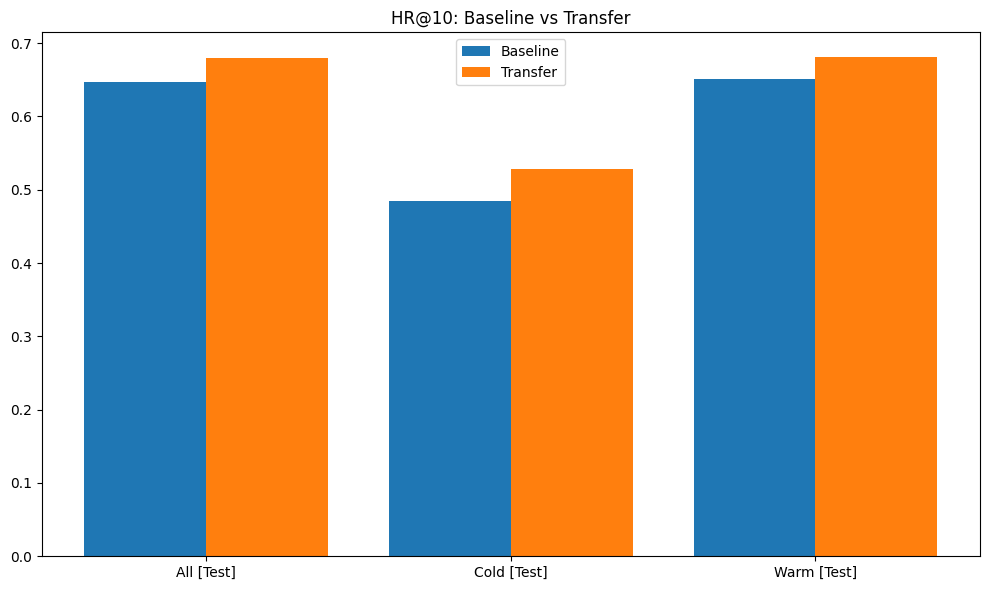

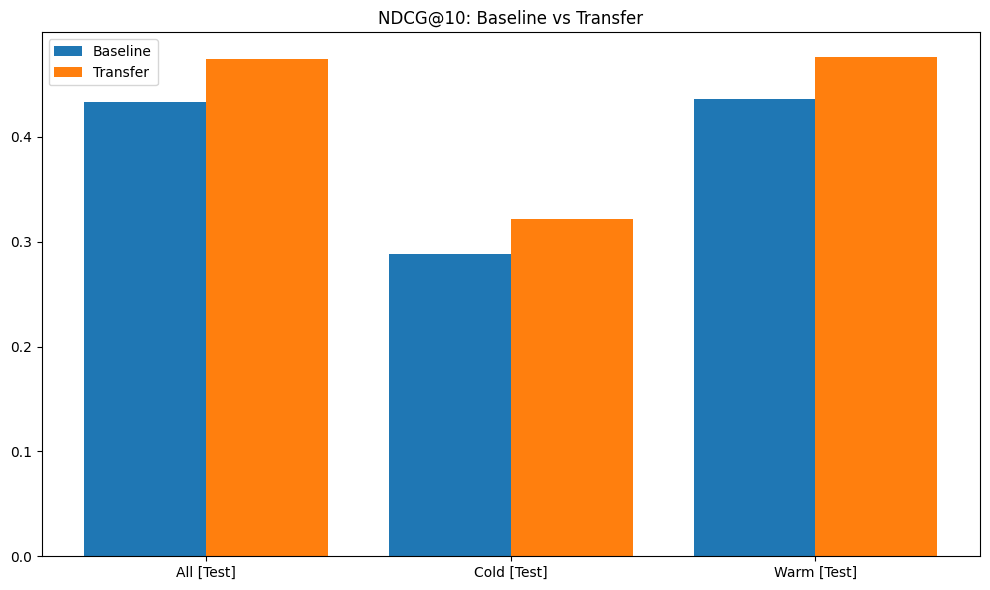

Saved charts: hr10.png, ndcg10.png


In [39]:
# Bar plots
def barplot_metric(df, metric_col_baseline, metric_col_transfer, title, outfile):
    labels = df["Split"].tolist()
    baseline = df[metric_col_baseline].tolist()
    transfer = df[metric_col_transfer].tolist()
    xs = range(len(labels))
    plt.figure(figsize=(10,6))
    plt.bar(xs, baseline, width=0.4, label="Baseline")
    plt.bar([i+0.4 for i in xs], transfer, width=0.4, label="Transfer")
    plt.xticks([i+0.2 for i in xs], labels)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=160)
    plt.show()

barplot_metric(results_df, "Baseline HR@10", "Transfer HR@10", "HR@10: Baseline vs Transfer", "hr10.png")
barplot_metric(results_df, "Baseline NDCG@10", "Transfer NDCG@10", "NDCG@10: Baseline vs Transfer", "ndcg10.png")
print("Saved charts: hr10.png, ndcg10.png")

## Experiment with Reinforcement Learning

In [48]:
# Feedback -> reward mapping
FEEDBACK_REWARD = {
    "like": 1.0, "purchase": 1.0, "click": 0.3,
    "add_to_cart": 0.7, "dislike": -0.5, "skip": 0.0
}

def events_to_rewards(events, device="cpu"):
    """events: list[str] length B -> Tensor[B] float rewards"""
    reward = [FEEDBACK_REWARD.get(event, 0.0) for event in events]
    return torch.tensor(reward, dtype=torch.float32, device=device)

# Tiny policy-gradient trainer wrapping transfer model
class PolicyGradientTrainer:
    def __init__(self, model, lr=5e-5, entropy_coeff=0.01, temperature=1.0, baseline_momentum=0.9, log_rewards=False, log_every=10, device="cpu"):
        self.model = model.to(device)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.entropy_coeff = entropy_coeff
        self.temperature = temperature
        self.device = device
        self._baseline = 0.0
        self._mom = baseline_momentum
        self.log_rewards = log_rewards
        self.log_every = log_every
        self._step = 0

    def _scores(self, input_seq, xfer_src, candidates):
        candidates = candidates.long()
        input_seq = input_seq.long()

        fused = self.model(input_seq, transfer_src=xfer_src)                   # [B, D]
        cand_emb = self.model.base.item_embed(candidates)                      # [B, N, D]
        scores = torch.bmm(cand_emb, fused.unsqueeze(-1)).squeeze(-1)          # [B, N]
        return scores

    def _policy_loss(self, logits, actions, rewards):
        logp_all = torch.log_softmax(logits / self.temperature, dim=1)         # [B, N]
        probs = torch.exp(logp_all)                                            # [B, N]
        logp_act = logp_all.gather(1, actions.view(-1,1)).squeeze(1)           # [B]
        entropy = -(probs * logp_all).sum(dim=1)                               # [B]

        # moving baseline to reduce variance
        with torch.no_grad():
            self._baseline = self._mom * self._baseline + (1 - self._mom) * rewards.mean().item()
        adv = rewards - self._baseline

        # Objective: maximize E[(R - b) * log pi(a|s)] + beta * H
        loss = -(adv * logp_act + self.entropy_coeff * entropy).mean()
        return loss, logp_act.mean().item(), entropy.mean().item(), adv.mean().item()

    def step_offline_demo_batch(self, batch, sample_actions=True):
        self.model.train()
        inp = batch["input_seq"].to(self.device)            # [B, L]
        tgt = batch["target"].to(self.device)               # [B]
        neg = batch["neg_items"].to(self.device)            # [B, nNeg]
        xfer = batch["transfer_src"].to(self.device)        # [B, D]

        candidates = torch.cat([tgt.unsqueeze(1), neg], dim=1)                  # [B, N]
        logits = self._scores(inp, xfer, candidates)                             # [B, N]

        if sample_actions:
            probs = torch.softmax(logits / self.temperature, dim=1)             # [B, N]
            actions = torch.multinomial(probs, num_samples=1).squeeze(1)        # [B]
        else:
            actions = torch.argmax(logits, dim=1)                                # [B]

        # Demo feedback: treat correct pick as a 'click', else 'skip'
        events = ["click" if a.item() == 0 else "skip" for a in actions]
        rewards = events_to_rewards(events, device=self.device)                  # [B]

        # LOG REWARDS
        if self.log_rewards and (self._step % self.log_every == 0):
            r = rewards.detach().cpu().numpy()
            r_head = np.round(r[:10], 3)  # show first 10
            print(f"   [rewards] mean={r.mean():.3f} std={r.std():.3f} "
                  f"min={r.min():.3f} p50={np.median(r):.3f} p90={np.quantile(r,0.9):.3f} max={r.max():.3f} "
                  f"head={r_head.tolist()}\n")

        self._step += 1

        loss, mean_logp, mean_H, mean_adv = self._policy_loss(logits, actions, rewards)
        self.opt.zero_grad(); loss.backward(); self.opt.step()

        acc = (actions == 0).float().mean().item()  # “hit-rate” on the demo task
        return {"loss": loss.item(), "avg_reward": rewards.mean().item(),
                "hit_rate": acc, "mean_logp": mean_logp, "entropy": mean_H, "adv": mean_adv}

    def offline_demo_finetune(self, loader, steps=1, sample_actions=True):
        for ep in range(steps):
            stats = []
            for batch in loader:
                s = self.step_offline_demo_batch(batch, sample_actions=sample_actions)
                stats.append(s)
            m = {k: float(np.mean([x[k] for x in stats])) for k in stats[0].keys()}
            print(f"[RL demo] Epoch {ep+1}/{steps}  loss {m['loss']:.4f}  "
                  f"avg_reward {m['avg_reward']:.4f}  hit {m['hit_rate']:.4f}  "
                  f"H {m['entropy']:.4f}  advantage {m['adv']:.4f}\n")


print("\n=== RL OFFLINE DEMO: fine-tune on VAL, evaluate on TEST ===")
# Evaluate BEFORE RL (for comparison)
ev_before = evaluate_transfer(transfer_model, test_loader_tgt, nn.BCEWithLogitsLoss(), device=DEVICE, k=10)
print("[Before RL]  HR@10={:.4f}  NDCG@10={:.4f}  Precision@10={:.4f}  MRR={:.4f}".format(
    ev_before["HR@K"], ev_before["NDCG@K"], ev_before["Precision@K"], ev_before["MRR"]))

# Run a tiny amount of RL demo training
rl = PolicyGradientTrainer(
    transfer_model,
    lr=3e-5,
    entropy_coeff=0.01,
    temperature=1.0,
    baseline_momentum=0.9,
    log_rewards=True,
    log_every=50,
    device=DEVICE
)

rl.offline_demo_finetune(val_loader_tgt, steps=20, sample_actions=True)

# Evaluate AFTER RL
ev_after = evaluate_transfer(transfer_model, test_loader_tgt, nn.BCEWithLogitsLoss(), device=DEVICE, k=10)
print("[After  RL]  HR@10={:.4f}  NDCG@10={:.4f}  Precision@10={:.4f}  MRR={:.4f}".format(
    ev_after["HR@K"], ev_after["NDCG@K"], ev_after["Precision@K"], ev_after["MRR"]))


=== RL OFFLINE DEMO: fine-tune on VAL, evaluate on TEST ===


Evaluating: 100%|██████████| 207/207 [00:14<00:00, 14.17it/s]


[Before RL]  HR@10=0.6757  NDCG@10=0.4766  Precision@10=0.0676  MRR=0.4282
   [rewards] mean=0.105 std=0.143 min=0.000 p50=0.000 p90=0.300 max=0.300 head=[0.0, 0.0, 0.0, 0.30000001192092896, 0.30000001192092896, 0.0, 0.0, 0.30000001192092896, 0.0, 0.30000001192092896]

   [rewards] mean=0.101 std=0.142 min=0.000 p50=0.000 p90=0.300 max=0.300 head=[0.30000001192092896, 0.0, 0.0, 0.0, 0.0, 0.30000001192092896, 0.0, 0.0, 0.30000001192092896, 0.0]

   [rewards] mean=0.106 std=0.143 min=0.000 p50=0.000 p90=0.300 max=0.300 head=[0.30000001192092896, 0.0, 0.30000001192092896, 0.0, 0.30000001192092896, 0.30000001192092896, 0.30000001192092896, 0.0, 0.0, 0.0]

   [rewards] mean=0.100 std=0.141 min=0.000 p50=0.000 p90=0.300 max=0.300 head=[0.30000001192092896, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

   [rewards] mean=0.096 std=0.140 min=0.000 p50=0.000 p90=0.300 max=0.300 head=[0.0, 0.0, 0.30000001192092896, 0.0, 0.0, 0.30000001192092896, 0.0, 0.0, 0.0, 0.0]

[RL demo] Epoch 1/20  loss -0.

Evaluating: 100%|██████████| 207/207 [00:14<00:00, 14.05it/s]

[After  RL]  HR@10=0.6750  NDCG@10=0.4771  Precision@10=0.0675  MRR=0.4291


In [49]:
import torch

@torch.no_grad()
def sample_recommendations(
    raw_user,
    k=10,
    model=transfer_model,                    # or sasrec_tgt_baseline
    user_encoder=user_encoder_tgt,
    item_encoder=item_encoder_tgt,
    sequences=train_sequences_tgt,          # {encoded_uid: [item_ids...]}
    xfer_mat=transfer_src_mat,              # None if using baseline
    max_len=50,
    device=DEVICE,
    pop_items=None                          # optional: precomputed popular raw items
):
    # Unknown user → fallback
    if raw_user not in user_encoder.classes_:
        return (pop_items or [])[:k]

    uid = int(user_encoder.transform([raw_user])[0])
    seq = sequences.get(uid, [])
    seen = set(seq)

    # Build left-padded input
    seq = seq[-max_len:]
    inp = torch.tensor([[0]*(max_len-len(seq)) + seq], dtype=torch.long, device=device)

    # Get fused user vector (transfer) or last hidden (baseline)
    if hasattr(model, "base"):  # SASRecCD
        xfer = None if xfer_mat is None else xfer_mat[uid:uid+1].to(device)
        fused = model(inp, transfer_src=xfer)                 # [1, D]
        W = model.base.item_embed.weight                      # [I, D]
    else:                   # plain SASRec
        seq_repr = model(inp)                                 # [1, L, D]
        fused = seq_repr[:, -1, :]                            # [1, D]
        W = model.item_embed.weight                           # [I, D]

    # Score all items, mask padding & seen
    scores = fused @ W.T                                      # [1, num_items]
    scores[:, 0] = -1e9
    if seen:
        scores[0, list(seen)] = -1e9

    topk_ids = torch.topk(scores, k, dim=1).indices.squeeze(0).tolist()
    # decode back to raw item ids (shift_item_id=True → subtract 1)
    rec_items = [item_encoder.inverse_transform([i-1])[0] for i in topk_ids]
    return rec_items

# Example:
u = filtered_df_target["user"].iloc[20]
print(sample_recommendations(u, k=10))

['B093CNZ7ST', 'B09QH98YG1', 'B09F59CZ7R', 'B097YYZ87F', 'B09ML1QV1S', 'B08QZN6LCM', 'B09JB21878', 'B09HYNH8TK', 'B09PVRLSLB', 'B08WJN83XZ']
